# Generative Adversarial Network Example

Build a generative adversarial network (GAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Classifier Model

In [4]:
# Training Parameters
learning_rate_cnn = 0.001
num_steps_cnn = 1500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
#     fc1 = tf.nn.dropout(fc1, dropout)

    #fc2
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    # Apply Dropout
#     fc2 = tf.nn.dropout(fc2, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

In [6]:
# Store layers weight & bias
weights_cnn = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 120 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 120])),
    # fully connected, 120 inputs, 84 outputs
    'wd2': tf.Variable(tf.random_normal([120, 84])),
    # 84 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([84, num_classes]))
}

biases_cnn = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([120])),
    'bd2': tf.Variable(tf.random_normal([84])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights_cnn, biases_cnn, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
loss_sc = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_cnn)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Discriminator Model

In [7]:
# Training Parameters
learning_rate_discriminator = 0.0001
batch_size_discriminator = 128

# Network Parameters
num_input_discriminator = 784 # MNIST data input (img shape: 28*28)
num_classes_discriminator = 1 # One score for each image
dropout_discriminator = 0.5 # Dropout, probability to keep units

In [8]:
# Create model
def cnn_dis(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

        # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
        # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

        # Fully connected layer
        # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
        # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
        # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [9]:
# Discriminator's weights and bias
weights_dis = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, 2]))
}

biases_dis = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([2]))
}

X_dis = tf.placeholder(tf.float32, [None, num_input_discriminator])
Y_dis = tf.placeholder(tf.float32, [None, 2])
dis_logist = cnn_dis(X_dis, weights_dis, biases_dis, dropout_discriminator)
dis_prediction = tf.nn.softmax(dis_logist)

# Discriminator's loss and optimizer
loss_dis = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=dis_logist, labels=Y_dis))
loss_dis_sc = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=dis_logist, labels=Y_dis))
opt_dis = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator)
train_dis = opt_dis.minimize(loss_dis)

### Target classifier output layer gradient to look at

In [10]:
zero = tf.slice(logits,begin=[0,0],size=[128,1])
#grad = tf.gradients(tf.reduce_mean(zero), X)
grad = tf.gradients(loss_sc, X)
grad_dis = tf.gradients(loss_dis_sc, X_dis)

# Training

In [ ]:
from IPython import display
# Training the classifier
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.15)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#with tf.Session() as sess:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [ ]:
for step in range(1, num_steps_cnn+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y,
                                                             keep_prob: 1.0})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))
# save_path = saver.save(sess, "./modles/MNSTClassodel.ckpt")
print("Optimization Finished!")

# Calculate accuracy for 256 MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                  Y: mnist.test.labels[:256],
                                  keep_prob: 1.0}))

In [18]:
# True image will have prediction (1, 0), fake image will have prediction(0, 1)
y_fake = np.zeros((batch_size_discriminator, 2))
y_real = np.zeros((batch_size_discriminator, 2))
y_fake[:,1] = 1
y_real[:,0] = 1
# First half is fake image, second half is real image
y_half = np.zeros((batch_size_discriminator, 2))
y_half[:batch_size_discriminator//2, 1] = 1
y_half[batch_size_discriminator//2:, 0] = 1

In [19]:
# Clip the image based on percentile and rescale 
def clip_and_recenter(middle_percentile, img):
    percentile = 100-(100-middle_percentile)/2
    upper_bound = np.percentile(img, percentile, axis = 1)
    lower_bound = np.percentile(img, 100 - percentile, axis = 1)
    img = np.divide(np.subtract(img.T, lower_bound), (upper_bound-lower_bound)).T
    # Clip the image
    img[img > 1] = 1
    img[img < 0] = 0
    return img

In [20]:
n = 10
canvas = np.empty((28 * n, 28 * n))

In [21]:
my_Y = np.zeros((128,10))
for i in range(128):
    my_Y[i][i%10]= 1
#print(my_Y)
from ipywidgets import widgets
from ipywidgets import IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Checkbox
from ipywidgets import ToggleButton
from math import sqrt
import threading
import time
style = {'description_width': 'initial'}

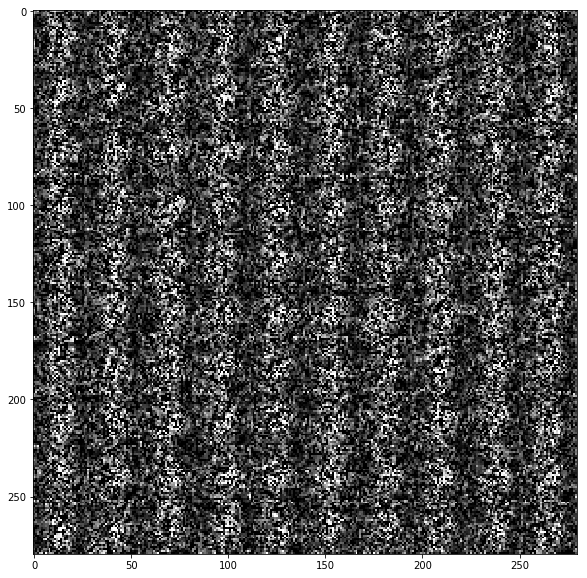

0.0 3.14897722985
iter=17
Picture No.9
Discriminator has been trained 71 times


FloatSlider(value=0.0, description=u'Gradient Noise Level', style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.01, description=u'LR', max=1.0, step=0.01, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.5, description=u'weight of dis', max=1.0, step=0.01, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.05, description=u'L2 Regularization', max=0.5, step=0.01, style=SliderStyle(description_width=u'initial'))

IntSlider(value=18, description=u'Iter count', min=1, style=SliderStyle(description_width=u'initial'))

Checkbox(value=False, description=u'Stop Training Discriminator')

ToggleButton(value=False, button_style=u'danger', description=u'Stop', icon=u'check', tooltip=u'Stop')

Discriminator prediction=[ 0.8046875  0.1953125] -73249.1 -62107.6 After 49 steps
Classifier accuracy=1.0
Still training discriminator


In [22]:
grad_noise_slider = FloatSlider(description='Gradient Noise Level', style=style)
lr_slider = FloatSlider(description = 'LR', style=style,min=0,max=1,step=0.01,value=0.01)
dWeight_slider = FloatSlider(description = 'weight of dis',min=0,max=1,step=0.01,style=style,value=0.5)
l2_reg_slider = FloatSlider(description = 'L2 Regularization',min=0,max=0.5,step=0.01,style=style,value=0.05)
iter_slider = IntSlider(description = 'Iter count',min=1,max=100,step=1,style=style,value=6)
stop_training_dis_check = Checkbox(description = 'Stop Training Discriminator', value=False)
stop_button = ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop',
    icon='check'
)
def work():
    accumulateDiscriminator = np.zeros((batch_size_discriminator, num_input_discriminator))
    accumulateClassifier = np.zeros((batch_size_discriminator, num_input_discriminator))
    momentum = np.zeros((batch_size_discriminator, num_input_discriminator))
    # Train Discriminator
    train_no = 0
    noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
    img = noise_img
    for j1 in range(10):
        noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
        img = noise_img
        accumulateDiscriminator[:] = 0
        accumulateClassifier[:] = 0
        momentum[:] = 0
        for k in range(iter_slider.value):
            st, end = 0, 0
            learning_rate = lr_slider.value
            dWeight = dWeight_slider.value      
            stop_training_dis = stop_training_dis_check.value
            reg = l2_reg_slider.value
            if(stop_button.value): return
            for step in range(50):
                # Run the sesssion
                g, ll, p, class_accuracy, dis_score2, dl_, g_from_dis = sess.run(
                    [grad, loss_op, prediction, accuracy, dis_prediction, dis_logist, grad_dis], \
                    feed_dict={X: img, Y: my_Y, X_dis: img, Y_dis:y_real, keep_prob: 1.0})
                # Score for discriminator
                dis_score = np.mean(dis_score2, axis = 0)
                # Accumulate and Normalize the gradient
                accumulateClassifier = 0.1 * g[0] ** 2 + 0.9 * accumulateClassifier
                accumulateDiscriminator = 0.1 * g_from_dis[0] ** 2 + 0.9 * accumulateDiscriminator
                normalized_class_grad = g[0] / np.sqrt(accumulateClassifier + 1e-8)
                normalized_dis_grad = g_from_dis[0] / np.sqrt(accumulateDiscriminator + 1e-14)

                # Add the gradient from discriminator and classifier
                gg = (1-dWeight) * (normalized_class_grad)
                gg += (dWeight) * (normalized_dis_grad) +float(grad_noise_slider.value)/10*np.random.normal(0,1,(batch_size_discriminator, num_input_discriminator))
                gg -= reg*img
                momentum = 0.9*momentum + 0.1 * gg
                img += momentum * learning_rate
#                 # Clipping the image to range 0-1
                img[img > 1] = 1
                img[img < 0] = 0
#                 img = clip_and_recenter(99, img)
                if (step == 0):
                    st = dl_.mean()
                if (dis_score[0] > 0.9 and not stop_training_dis):
                    break
            for i in range(n):
                for j in range(n):
                    # Draw the generated digits
                    canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img[i * n + j].reshape([28, 28])        
            plt.figure(figsize=(n, n))
            plt.imshow(canvas, origin="upper", cmap="gray")
            plt.show()
            print(normalized_class_grad.max(),normalized_dis_grad.max())
            print('iter=' + str(k))
            print('Picture No.'+str(j1))
            print('Discriminator has been trained '+str(train_no)+' times')
            display.display(grad_noise_slider)
            display.display(lr_slider)
            display.display(dWeight_slider)
            display.display(l2_reg_slider)
            display.display(iter_slider)
            display.display(stop_training_dis_check)
            display.display(stop_button)
            print('Discriminator prediction=' + str(dis_score) + " "+ str(st)+" "+str(dl_.mean())+ " After " + str(step)+ " steps")
            print('Classifier accuracy=' + str(class_accuracy))
            batch_x, _ = mnist.train.next_batch(batch_size_discriminator)
            if not stop_training_dis:
                print("Still training discriminator")
                train_no+=1
                # Train Discriminator for two iterations, random mix fake and real image
                first_half = np.append(img[:batch_size_discriminator// 2], batch_x[:batch_size_discriminator// 2], axis = 0)
                second_half = np.append(img[batch_size_discriminator// 2:], batch_x[batch_size_discriminator// 2:], axis = 0)
                first_half_index = np.random.permutation(batch_size_discriminator)
                second_half_index = np.random.permutation(batch_size_discriminator)
                sess.run([train_dis], feed_dict={X_dis: first_half[first_half_index], Y_dis: y_half[first_half_index]})
                sess.run([train_dis], feed_dict={X_dis: second_half[second_half_index], Y_dis: y_half[second_half_index]})
            display.clear_output(wait=True)
            time.sleep(0.1)
thread = threading.Thread(target=work)
thread.start()


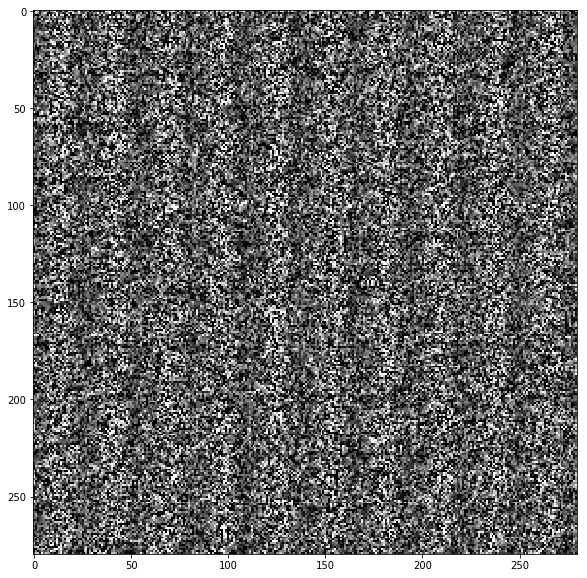

3.16227703129 3.14724411702
iter=5
Picture No.7
Discriminator has been trained 47 times


FloatSlider(value=0.0, description=u'Gradient Noise Level', style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.01, description=u'LR', max=1.0, step=0.01, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.5, description=u'weight of dis', max=1.0, step=0.01, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.05, description=u'L2 Regularization', max=0.5, step=0.01, style=SliderStyle(description_width=u'initial'))

IntSlider(value=6, description=u'Iter count', min=1, style=SliderStyle(description_width=u'initial'))

Checkbox(value=False, description=u'Stop Training Discriminator')

ToggleButton(value=False, button_style=u'danger', description=u'Stop', icon=u'check', tooltip=u'Stop')

Discriminator prediction=[ 0.921875  0.078125] -69882.9 -60367.7 After 46 steps
Classifier accuracy=0.992188
Still training discriminator


In [23]:
accumulateDiscriminator = np.zeros((batch_size_discriminator, num_input_discriminator))
accumulateClassifier = np.zeros((batch_size_discriminator, num_input_discriminator))
for i in range(1):
    noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
    img = noise_img
    g, ll, p, dis_score, dl_, g_from_dis = sess.run(
                    [grad, loss_op, prediction, dis_prediction, dis_logist, grad_dis], \
                    feed_dict={X: img, Y: my_Y, X_dis: img, Y_dis:y_real, keep_prob: 1.0})
    accumulateClassifier = 0.1 * g[0] ** 2 + 0.9 * accumulateClassifier
    accumulateDiscriminator = 0.1 * g_from_dis[0] ** 2 + 0.9 * accumulateDiscriminator
    normalized_class_grad = g[0] / np.sqrt(accumulateClassifier + 1e-8)
    normalized_dis_grad = g_from_dis[0] / np.sqrt(accumulateDiscriminator+1e-14)

In [ ]:
#dis_img2 = tf.reduce_mean((dis_score_fake))
#dis_grad2 = tf.gradients(dis_img2, X_fake)
sess.run([grad,grad_dis], feed_dict={X:img, Y: my_Y, X_dis: img, Y_dis: y_real, keep_prob: 1.0})

In [ ]:
normalized_class_grad

In [ ]:
normalized_dis_grad